$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/tal.r/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/tal.r/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/tal.r/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


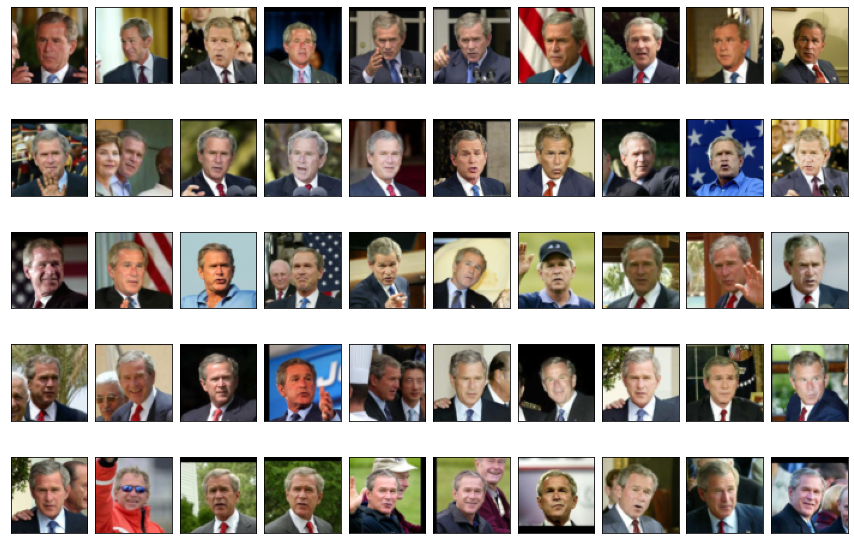

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (flatten): Linear(in_features=16384, out_features=1, bias=True)
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
  (linear): Linear(in_features=128, out_features=16384, bias=True)
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

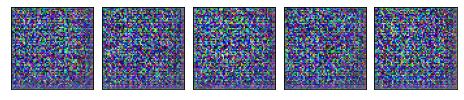

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 4, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.99)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.99)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
Discriminator loss: 1.3687921157654594
Generator loss:     10.597953936632942


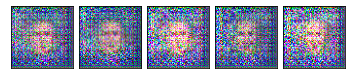

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.64it/s]
Discriminator loss: 0.7453777467941537
Generator loss:     7.795999302583582


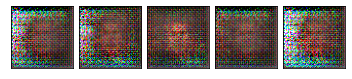

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.72it/s]
Discriminator loss: 1.4490364465643377
Generator loss:     5.118890317047343


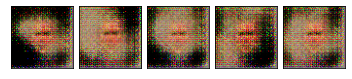

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.70it/s]
Discriminator loss: 0.6758973791318781
Generator loss:     2.919074731714585
Saved checkpoint.


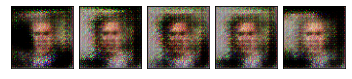

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
Discriminator loss: 1.0727176192928762
Generator loss:     3.156718506532557
Saved checkpoint.


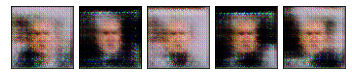

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.65it/s]
Discriminator loss: 1.0488448125474594
Generator loss:     3.760477030978483


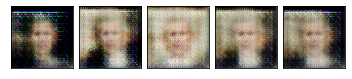

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.61it/s]
Discriminator loss: 0.8943980967297274
Generator loss:     3.372200236600988


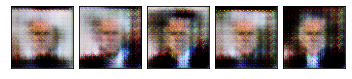

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.70it/s]
Discriminator loss: 0.8894501819330103
Generator loss:     3.6717150141211117
Saved checkpoint.


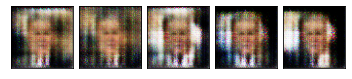

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
Discriminator loss: 1.0471870092784656
Generator loss:     3.6660856639637665


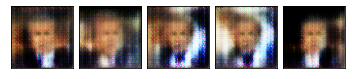

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.67it/s]
Discriminator loss: 0.8394302830976599
Generator loss:     3.0810628358055565
Saved checkpoint.


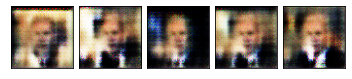

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.64it/s]
Discriminator loss: 1.1382394713513992
Generator loss:     3.5762756501927093


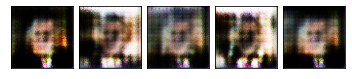

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
Discriminator loss: 0.8539060161394232
Generator loss:     3.7156750875360824


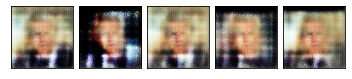

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
Discriminator loss: 0.7390222163761363
Generator loss:     3.9916387165293976


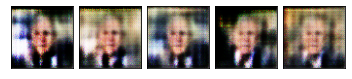

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
Discriminator loss: 0.715043401455178
Generator loss:     4.170513377470129


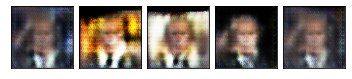

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.63it/s]
Discriminator loss: 0.8928559589035371
Generator loss:     4.007720189936021


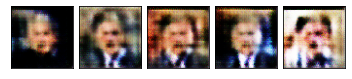

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
Discriminator loss: 0.79575675638283
Generator loss:     4.382399348651662


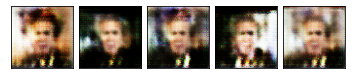

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.6906244106152478
Generator loss:     4.487350646187277


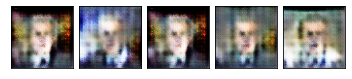

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
Discriminator loss: 0.5203405750148437
Generator loss:     4.786657277275534


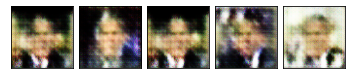

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.8714026861331042
Generator loss:     5.292223215103149


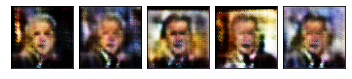

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
Discriminator loss: 0.7658758759498596
Generator loss:     5.009173554532668


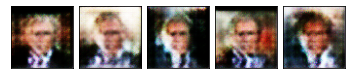

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.5990386219585643
Generator loss:     5.089686940698063
Saved checkpoint.


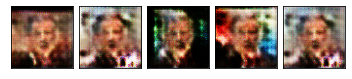

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.5415830489467172
Generator loss:     5.013177058276008


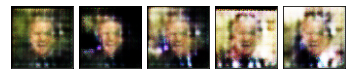

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.7687535877613461
Generator loss:     5.266466491362628


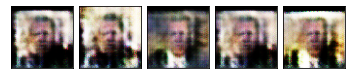

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.62it/s]
Discriminator loss: 0.7200641579487744
Generator loss:     4.307774719069986


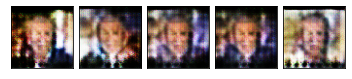

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.5928275642149589
Generator loss:     4.9157918621512025
Saved checkpoint.


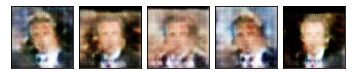

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.61it/s]
Discriminator loss: 0.5390444901936194
Generator loss:     5.495094663956586


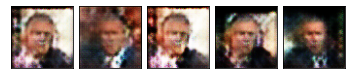

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
Discriminator loss: 0.5126533109475585
Generator loss:     5.150843536152559


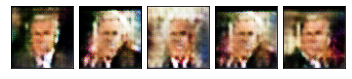

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.41150490282212987
Generator loss:     5.575077225180233


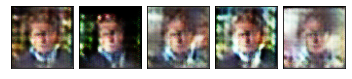

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.8448021464488086
Generator loss:     5.2216512595905975


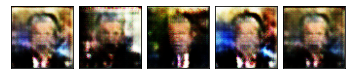

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.36600004224216237
Generator loss:     5.804453653447768


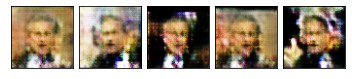

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.3695596745785545
Generator loss:     6.618302219054279


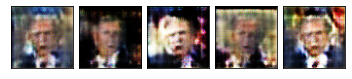

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.7486391492626246
Generator loss:     5.469777527977438


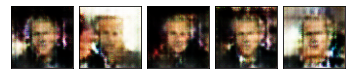

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.4889012881938149
Generator loss:     5.140636724584243


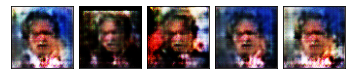

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.39112267117289934
Generator loss:     6.5575794191921455


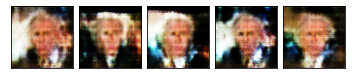

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.7731939564075541
Generator loss:     5.627653626834645


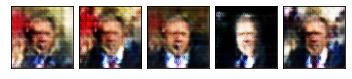

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
Discriminator loss: 0.5035816691815853
Generator loss:     5.266443434883566


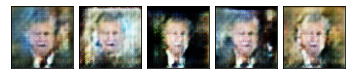

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.479262352866285
Generator loss:     5.772578491884119


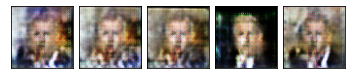

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.3737713361487669
Generator loss:     6.3007317991817695


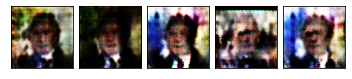

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.3026555991348098
Generator loss:     6.317666306215174


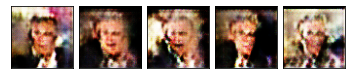

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.3310277154121329
Generator loss:     7.044432752272662


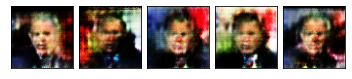

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.5907923539771753
Generator loss:     7.445226557114545


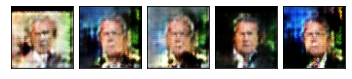

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.4323918714242823
Generator loss:     5.478950360242059


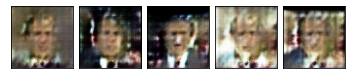

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
Discriminator loss: 0.5324846497353386
Generator loss:     7.051200838649974
Saved checkpoint.


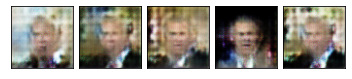

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
Discriminator loss: 0.4420340411803302
Generator loss:     6.703069238101735


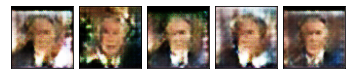

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.254093616762582
Generator loss:     6.8490418265847595
Saved checkpoint.


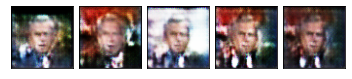

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.40692354782539253
Generator loss:     7.793828795937931


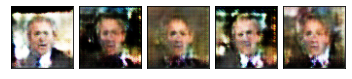

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.3468475508339265
Generator loss:     6.414452636943144


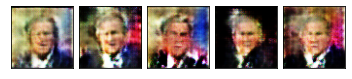

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
Discriminator loss: 0.2644627805360976
Generator loss:     7.290988894069896
Saved checkpoint.


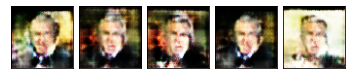

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
Discriminator loss: 0.2720303583671065
Generator loss:     7.990272353677189


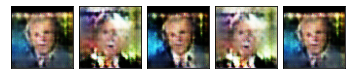

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.20840508151142037
Generator loss:     8.58718594382791


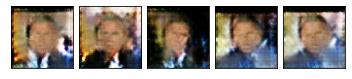

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.5230155558708836
Generator loss:     8.028647731332217


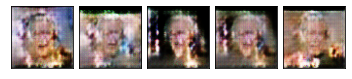

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.2532957009971142
Generator loss:     6.9867063129649445


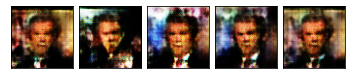

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
Discriminator loss: 0.21314705250894322
Generator loss:     6.995286717134364
Saved checkpoint.


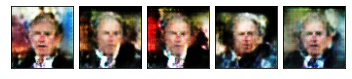

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.5035999759155161
Generator loss:     8.131016226375804


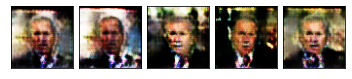

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.25574299671194134
Generator loss:     7.354196324067957


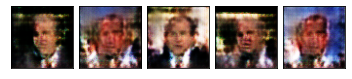

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.36546818912029266
Generator loss:     7.19663423650405
Saved checkpoint.


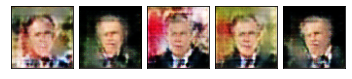

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
Discriminator loss: 0.19092888450797865
Generator loss:     7.579022407531738


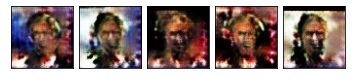

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
Discriminator loss: 0.11545712687075138
Generator loss:     6.638127944048713
Saved checkpoint.


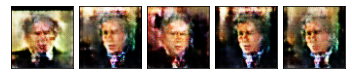

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
Discriminator loss: 0.5442311093211174
Generator loss:     7.365904401330387


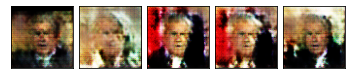

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.25056172830655293
Generator loss:     6.986950187122121


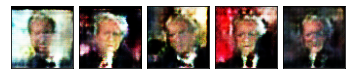

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.27748722363920775
Generator loss:     8.2945055400624


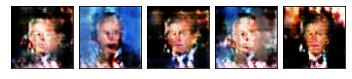

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.22749030957108035
Generator loss:     9.198413372039795


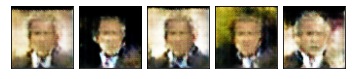

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
Discriminator loss: 0.27401006166987557
Generator loss:     8.26684960197
Saved checkpoint.


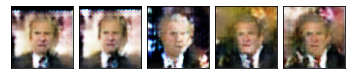

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.4017600419328493
Generator loss:     8.926264987272376


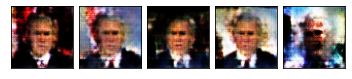

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.50it/s]
Discriminator loss: 0.26387319954879146
Generator loss:     7.172547228196088
Saved checkpoint.


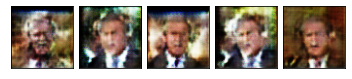

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.7216299312079654
Generator loss:     7.877212314044728


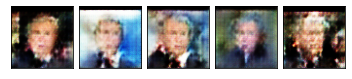

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
Discriminator loss: 0.2120947763323784
Generator loss:     7.111602418562946
Saved checkpoint.


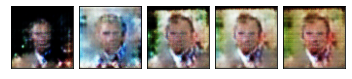

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.23267527932629867
Generator loss:     6.917204239789178
Saved checkpoint.


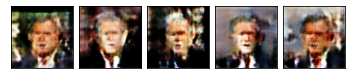

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
Discriminator loss: 0.10407991652541301
Generator loss:     7.186772963579963


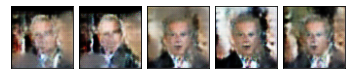

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.43090079593307834
Generator loss:     8.645269113428453


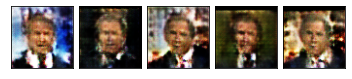

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.1617605900939773
Generator loss:     7.665558029623592


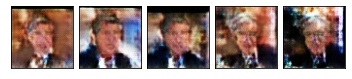

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.5727887942510492
Generator loss:     9.02552342414856


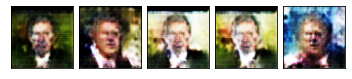

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.2240339153829743
Generator loss:     7.344865518457749


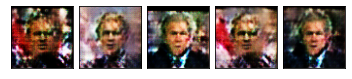

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
Discriminator loss: 0.12431568498997127
Generator loss:     7.83256282525904
Saved checkpoint.


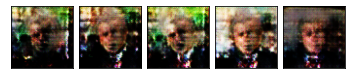

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
Discriminator loss: 0.3352799747577485
Generator loss:     7.68310967613669


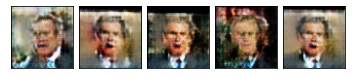

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.16426550881827578
Generator loss:     7.639457422144273


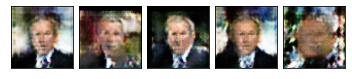

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
Discriminator loss: 0.31469474075471654
Generator loss:     9.073343571494608


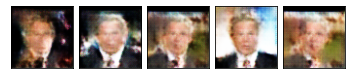

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
Discriminator loss: 0.18737244627931537
Generator loss:     7.298575709847843


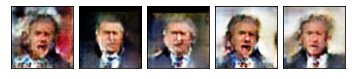

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.629780295140603
Generator loss:     8.561202862683464


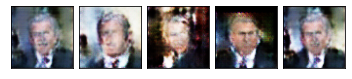

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
Discriminator loss: 0.22985811969813177
Generator loss:     5.899905120625215


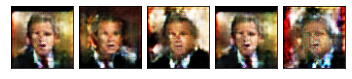

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.16521840422030756
Generator loss:     7.634655054877786
Saved checkpoint.


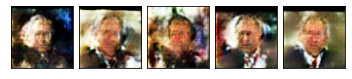

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
Discriminator loss: 0.0818397816927994
Generator loss:     7.378693412331974


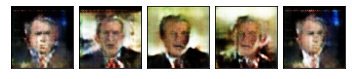

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
Discriminator loss: 0.22463832938057535
Generator loss:     8.05539108725155


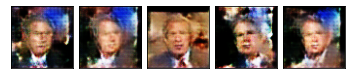

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.22021520828061245
Generator loss:     10.063086593852324


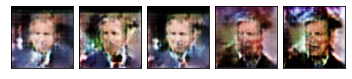

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.23119685842710383
Generator loss:     10.432017859290628


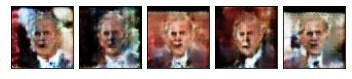

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.39998093576115723
Generator loss:     9.917597995084876


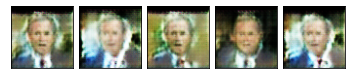

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.2209381568519508
Generator loss:     7.547923957600313
Saved checkpoint.


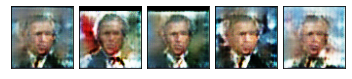

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
Discriminator loss: 0.17278862591175473
Generator loss:     7.190260634702795
Saved checkpoint.


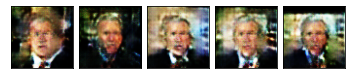

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.0576223400695359
Generator loss:     8.0687414337607


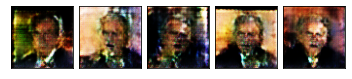

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.47it/s]
Discriminator loss: 0.31069159967934384
Generator loss:     9.309671738568474


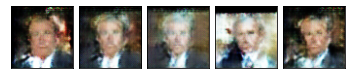

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.25191090168321834
Generator loss:     9.553768354303697


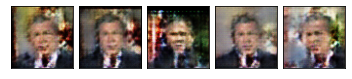

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.16455630607464733
Generator loss:     8.312699093538171
Saved checkpoint.


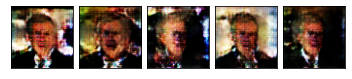

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.29568952497314005
Generator loss:     8.757419263615327


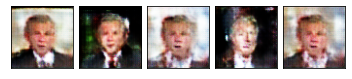

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.1422532110968057
Generator loss:     7.2009234147913315
Saved checkpoint.


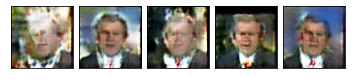

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
Discriminator loss: 0.07062558670911719
Generator loss:     8.180103666642133
Saved checkpoint.


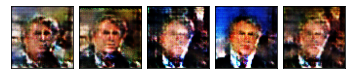

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.3427804368822014
Generator loss:     9.811053360209746


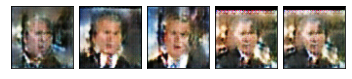

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.17571305198704495
Generator loss:     9.333539345685173


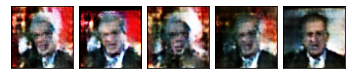

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
Discriminator loss: 0.11203430023263483
Generator loss:     7.845645680147059
Saved checkpoint.


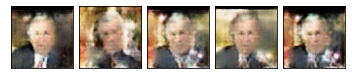

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
Discriminator loss: 0.23948106213527567
Generator loss:     9.12982988357544


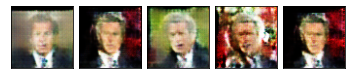

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
Discriminator loss: 0.11756093887721791
Generator loss:     8.469492267159854


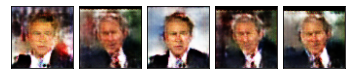

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


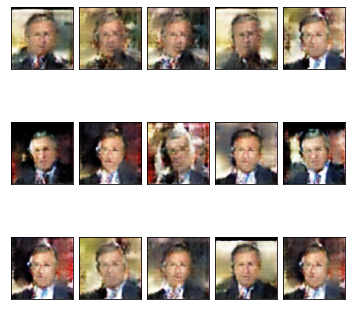

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


The GAN as we saw consists out of 2 parts - discriminator and generator. 
During the training process of both of them we generate fake data using the generator and feed it
into the discriminator along with real data in order to discriminate between them.
The discriminator simply behaves as a classifier and during that phase we keep the generator constant (we don't keep the 
generator gradients) in order to "help" the discriminator to converge and to allow it to learn the generator flaws.
During the generator training phase we need to keep of course its gradients in each step, but also we keep the
discriminator gradients as we want to backpropagate all the way from very end of the entire model, which is the 
discriminator output.  


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


1.  No, we shouldn't decide stopping training solely based on the generator loss as the it's score depends on the 
    discriminator performance: If the discriminator isn't accurate enough and the generator loss is very low it simply 
    means that the generator is performing well in fooling the discriminator. But since, the discriminator is doing a 
    lousy job in the first place, it doesn't mean that in overall the entire model is performing good enough.
2.  This means that the discriminator is ahead of the generator training wise. In other words it tells us that the 
    discriminator can easily tell the difference between the real and the generated data. While that, the generator 
    is trying to "catch" the discriminator and is learning from the results it provides


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


First, while the VAE and the GAN are similiar in their abilities to create new generated data, similiar to existing 
real one, they are very different in the approach they both take to achieve that goal. While the VAE learning approach 
is to compress the data correctly in order to be able to reconstruct it later, meaning it focuses directly on the data.
The GAN approach is to train a "cop" in a way so it will be able to distinguish between real and fake data, along 
with training a "counterfeiter" so it will be able to fool the cop and vice versa. Meaning, its approach is to create
a competition between the two adversaries so the focusing on the data is indirect in some sense.
We can see that in the VAE we got slightly better results due to the reasons above. Also we can see that because the VAE
focuses directly on the pictures, it also learned to distinguish meaningful areas such as the face part and to ignore
the background parts. Thats why the background parts are more blurry in the VAE and the face is much more precise, while
in the GAN there is much more similiarity (for better, but also mostly for worse) in the different parts of the generated
pictures.
Another possible reason for the poorer results in the GAN (compared to the VAE) since its training process is hard.
The generator and the discriminator are constantly trying to improve on the cost of each other so we can think at it
as trying to shoot at a moving target rather then the typical and constant training process of models we learned so far, including 
the VAE among them. 
